In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Common imports
import fitsio
import numpy as np
import os
import pandas as pd
import sys

In [3]:
# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rc('font', size=18)

In [4]:
# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [5]:
# QuasarNET imports
from quasarnet.models import QuasarNET, custom_loss
from quasarnet.io import read_truth, read_data, objective
from quasarnet.utils import process_preds, absorber_IGM

In [6]:
from astropy.io import fits
from astropy.table import Table, join, vstack, hstack

In [7]:
# To make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.compat.v1.reset_default_graph
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [8]:
def plot_spectrum(ival,X,c_line,z_line,zbest,Y,z,c_th=0.5,ndetect=1):
    llmin = np.log10(3600)
    llmax = np.log10(10000)
    dll = 1e-3

    nbins = int((llmax-llmin)/dll)
    wave = 10**(llmin + np.arange(nbins)*dll)
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    ax.plot(wave, X[ival,:])
    
    isqso_truth = (Y[ival,:].argmax()==2) | (Y[ival,:].argmax()==3)
    isqso_qn = (c_line[:,ival].sum()>c_th)>=ndetect
    
    title = r'Is QSO? VI: {}, QN: {}'.format(isqso_truth,isqso_qn)
    title += '\n'
    title += r'$z_{{VI}}$={:1.3f}, $z_{{QN}}$='.format(z[ival])
    if isqso_qn:
        title += r'{:1.3f}'.format(zbest[ival])
    else:
        title += 'N/A'
    
    ax.set_title(title)
    m = X[ival,:].min()
    M = X[ival,:].max()
    ax.grid()
    ax.set_ylim(m-2,M+2)
    for il,l in enumerate(lines):
        lam = absorber_IGM[l]*(1+z_line[il,ival])
        w = abs(wave-lam)<100
        if w.sum()>0:
            m = X[ival,w].min()-1
            M = X[ival,w].max()+1
            ax.plot([lam,lam], [m,M],'r--', alpha=0.1+0.9*c_line[il,ival])
            ax.text(lam,M+0.5,'c$_{{{}}}={}$'.format(l,round(c_line[il,ival],3)),
                     horizontalalignment='center',alpha=0.1+0.9*c_line[il,ival])
    ax.set_xlabel(r'$\lambda_\mathrm{obs}~[\AA]$')
    ax.set_ylabel(r'renormalised flux')
    plt.show()
    
    return

# Get blanc deep tile data, and run QuasarNET:

### parse_data_desisim --spectra /global/cfs/cdirs/desi/spectro/redux/blanc/tiles/80609/deep/coadd*.fits --out blanc-80606-deep.fits.gz --mode DESI_COADD --desi-period sv
### qn_export --model /global/cfs/projectdirs/desi/users/jfarr/QuasarNET_paper/qn_models/main_setup/coadd/prop_0.1/model_indtrain_0_0/qn_train_coadd_indtrain_0_0.h5 --data blanc-80609-deep.fits.gz --mode DESI_COADD --out-suffix output-806023-deep --data-training /global/cfs/projectdirs/desi/users/jfarr/QuasarNET_paper/data/coadd/training_datasets/prop_0.1/data_dr12_coadd_train_indtrain_0_0.fits 

# Get cascades data, and run QuasarNET:

### parse_data_desisim --spectra /global/cfs/cdirs/desi/spectro/redux/cascades/tiles/80609/deep/coadd*.fits --out cascades-80609-deep.fits.gz --mode DESI_COADD --desi-period sv
### qn_export --model /global/cfs/projectdirs/desi/users/jfarr/QuasarNET_paper/qn_models/main_setup/coadd/prop_0.1/model_indtrain_0_0/qn_train_coadd_indtrain_0_0.h5 --data cascades-80609-deep.fits.gz --mode DESI_COADD --out-suffix output-80609-cascades --data-training/global/cfs/projectdirs/desi/users/jfarr/QuasarNET_paper/data/coadd/training_datasets/prop_0.1/data_dr12_coadd_train_indtrain_0_0.fits 


# Loading results

In [9]:
def load_qn_tile(tile=80605):
    """Return QuasarNET results for a particular tile"""
    basedir='/global/cfs/cdirs/desi/users/font/test_qn_blanc/'
    fname=basedir+'qnAll-output-{}-deep.fits'.format(tile)
    hdul = fits.open(fname)
    data = Table(hdul[1].data)
    # remove columns that are not needed
    data.remove_columns(['IN_TRAIN','FIBER','BRICKNAME','BRICK_OBJID','Z_LINES_BAL','C_LINES_BAL'])
    data.rename_column('ZBEST', 'QN_Z')
    data.rename_column('IS_QSO', 'QN_IS_QSO')   
    # add spectra
    fname=basedir+'blanc-{}-deep.fits.gz'.format(tile)
    hdul_spectra = fits.open(fname)
    target_spectra = Table(hdul_spectra[1].data)
    target_spectra.remove_columns(['SPID0','SPID1','SPID2'])
    spectra = hdul_spectra[0].data[:,:443]
    spectra[:,434:443]=0
    target_spectra.add_column(spectra, name='spectra')
    data = join(data,target_spectra,keys='TARGETID')
    return data

In [34]:
def load_qn_ting_tile(tile,release):
    """Return QuasarNET results for a particular tile"""
    basedir='/global/homes/t/tanting/Machine_Learning_quasar/QuasarNET/test_qn_blanc_ting/'
    if release == 'blanc':
        fname=basedir+'qnAll-output-{}-deep.fits'.format(tile,release)
        fname_spectra=basedir+'{}-{}-deep.fits.gz'.format(release,tile)
    elif release == 'cascades':
        fname=basedir+'qnAll-output-{}-{}.fits'.format(tile,release)
        fname_spectra=basedir+'{}-{}-deep.fits.gz'.format(release,tile)
    hdul = fits.open(fname)
    data = Table(hdul[1].data)
    # remove columns that are not needed
    data.remove_columns(['IN_TRAIN','FIBER','BRICKNAME','BRICK_OBJID','Z_LINES_BAL','C_LINES_BAL'])
    data.rename_column('ZBEST', 'QN_Z')
    data.rename_column('IS_QSO', 'QN_IS_QSO')   
    # add spectra
    #fname=basedir+'blanc-{}.fits.gz'.format(tile)
    
    hdul_spectra = fits.open(fname_spectra)
    target_spectra = Table(hdul_spectra[1].data)
    target_spectra.remove_columns(['SPID0','SPID1','SPID2'])
    spectra = hdul_spectra[0].data[:,:443]
    spectra[:,434:443]=0
    target_spectra.add_column(spectra, name='spectra')
    data = join(data,target_spectra,keys='TARGETID')
    return data


In [35]:
qn_80605_blanc=load_qn_ting_tile('80605','blanc')
qn_80607_blanc=load_qn_ting_tile('80607','blanc')
qn_80609_blanc=load_qn_ting_tile('80609','blanc')

In [36]:
qn_80605_cascades=load_qn_ting_tile('80605','cascades')
qn_80607_cascades=load_qn_ting_tile('80607','cascades')
qn_80609_cascades=load_qn_ting_tile('80609','cascades')

In [54]:
def load_vi_tile(fname='desi-vi_QSO_tile80605_nightdeep_merged_all_210223.csv'):
    """Return VI truth table for a particular tile"""
    basedir='/global/cfs/cdirs/desi/sv/vi/TruthTables/Blanc/QSO/'
    data=Table.read(basedir+fname)
    # remove columns that are not needed
    data.remove_columns(['all_VI_issues','all_VI_comments','merger_comment','N_VI'])
    data.rename_column('Redrock_z', 'RR_Z')
    data.rename_column('Redrock_spectype', 'RR_CLASS')
    data.rename_column('best_z', 'VI_Z')
    data.rename_column('best_spectype', 'VI_CLASS')
    data.rename_column('best_quality', 'VI_QUALITY')
    return data

In [37]:
def load_wvi_tile(fname='80605_QSOzinfo_wVI.fits'):
    """Return VI truth table for a particular tile"""
    basedir='/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/blanc/v2/QSO/'
    data=Table.read(basedir+fname)
    # remove columns that are not needed
    data=data['TARGETID','Z','best_z','best_quality','SPECTYPE','best_spectype']
    data.rename_column('Z', 'RR_Z')
    data.rename_column('SPECTYPE', 'RR_CLASS')
    data.rename_column('best_z', 'VI_Z')
    data.rename_column('best_spectype', 'VI_CLASS')
    data.rename_column('best_quality', 'VI_QUALITY')
    return data

In [39]:
def load_vi(fname,release,vi_type):
    """Return VI truth table for a particular tile"""
    if release == 'blanc':
        basedir='/global/cfs/cdirs/desi/sv/vi/TruthTables/Blanc/QSO/'
    elif release == 'cascades':
        basedir='/global/cscratch1/sd/ajross/SV1/redshift_comps/cascades/testcas/QSO/'
    if vi_type == 'vi':
        data=Table.read(basedir+fname)
        # remove columns that are not needed
        data.remove_columns(['all_VI_issues','all_VI_comments','merger_comment','N_VI'])
        data.rename_column('Redrock_z', 'RR_Z')
        data.rename_column('Redrock_spectype', 'RR_CLASS')
        data.rename_column('best_z', 'VI_Z')
        data.rename_column('best_spectype', 'VI_CLASS')
        data.rename_column('best_quality', 'VI_QUALITY')
    elif vi_type == 'wvi':
        basedir='/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/blanc/v2/QSO/'
        data=Table.read(basedir+fname)
        # remove columns that are not needed
        data=data['TARGETID','Z','best_z','best_quality','SPECTYPE','best_spectype']
        data.rename_column('Z', 'RR_Z')
        data.rename_column('SPECTYPE', 'RR_CLASS')
        data.rename_column('best_z', 'VI_Z')
        data.rename_column('best_spectype', 'VI_CLASS')
        data.rename_column('best_quality', 'VI_QUALITY')
    return data

In [41]:
vi_80605_blanc=load_vi('desi-vi_QSO_tile80605_nightdeep_merged_all_210223.csv','blanc','vi')
vi_80607_blanc=load_vi('desi-vi_QSO_tile80607_nightdeep_merged_all_210214.csv','blanc','vi')
vi_80609_blanc=load_vi('desi-vi_QSO_tile80609_nightdeep_merged_all_210210.csv','blanc','vi')

In [42]:
vi_80605_cascades=load_vi('80605_QSOzinfo_wVI.fits','cascades','wvi')
vi_80607_cascades=load_vi('80607_QSOzinfo_wVI.fits','cascades','wvi')
vi_80609_cascades=load_vi('80609_QSOzinfo_wVI.fits','cascades','wvi')

# Merge VI tables with QN results

In [43]:
vi_qn_80605_blanc=join(vi_80605_blanc,qn_80605_blanc,keys='TARGETID')
vi_qn_80607_blanc=join(vi_80607_blanc,qn_80607_blanc,keys='TARGETID')
vi_qn_80609_blanc=join(vi_80609_blanc,qn_80609_blanc,keys='TARGETID')
# combine tiles
vi_qn_all_blanc=vstack([vi_qn_80605_blanc,vstack([vi_qn_80607_blanc,vi_qn_80609_blanc])])

In [47]:
vi_qn_80605_cascades=join(vi_80605_blanc,qn_80605_cascades,keys='TARGETID')
vi_qn_80607_cascades=join(vi_80607_blanc,qn_80607_cascades,keys='TARGETID')
vi_qn_80609_cascades=join(vi_80609_blanc,qn_80609_cascades,keys='TARGETID')
# combine tiles
vi_qn_all_cascades=vstack([vi_qn_80605_cascades,vstack([vi_qn_80607_cascades,vi_qn_80609_cascades])])

In [48]:
def print_summary(data,min_qual=2.5,min_z=0.0):
    n_tot=len(data)
    # only objects with good VI quality
    w_qual=data['VI_QUALITY']>=min_qual
    n_qual=len(data[w_qual])
    print('{:.3f} = ({} / {}) fraction of objects with VI quality >= {}'.format(n_qual/n_tot,n_qual,n_tot,min_qual))
    # objects identified as QSO by VI / Redrock / QuasarNET
    w_VI=(data['VI_CLASS']=='QSO') & (data['VI_Z'] > min_z)
    w_RR=data['RR_CLASS']=='QSO'
    w_QN=data['QN_IS_QSO']==True
    # matches for good spectra
    n_VI=len(data[w_qual & w_VI])
    print('{:.3f} = ({} / {}) fraction of good VI spectra are quasars'.format(n_VI/n_qual,n_VI,n_qual))    
    n_RR=len(data[w_qual & w_VI & w_RR])
    print('{:.3f} = ({} / {}) fraction of good VI quasars identified by Redrock'.format(n_RR/n_VI,n_RR,n_VI))    
    n_QN=len(data[w_qual & w_VI & w_QN])
    print('{:.3f} = ({} / {}) fraction of good VI quasars identified by QuasarNET'.format(n_QN/n_VI,n_QN,n_VI))
    n_intersection=len(data[w_qual & w_VI & w_RR & w_QN])
    print('{:.3f} = ({} / {}) fraction of good VI quasars identified by both Redrock and QuasarNET'.format(n_intersection/n_VI,n_intersection,n_VI))
    n_union=len(data[(w_qual & w_VI & w_RR)|(w_qual & w_VI & w_QN)])
    print('{:.3f} = ({} / {}) fraction of good VI quasars identified by either Redrock or QuasarNET'.format(n_union/n_VI,n_union,n_VI))
    
    w_high_z = (data['VI_Z'] > min_z)
    n_RR_total = len(data[w_qual & w_RR & w_high_z])
    n_RR_false=len(data[w_qual & ~w_VI & w_RR & w_high_z])
    print('{:.3f} = ({} / {}) fraction of VI targets false identified by Redrock as quasars'.format(n_RR_false/n_RR_total,n_RR_false,n_RR_total)) 
    
    n_QN_total = len(data[w_qual & w_QN & w_high_z])
    n_QN_false=len(data[w_qual & ~w_VI & w_QN & w_high_z])
    print('{:.3f} = ({} / {}) fraction of VI targets false identified by QuasarNET as quasars'.format(n_QN_false/n_QN_total,n_QN_false,n_QN_total)) 

In [50]:

#print('tile 80605')
#print_summary(data=vi_qn_80605,min_qual=2.5)
#print('tile 80607')
#print_summary(data=vi_qn_80607,min_qual=2.5)
#print('tile 80609')
#print_summary(data=vi_qn_80609,min_qual=2.5)
print('blanc all tiles')
print_summary(data=vi_qn_all_blanc,min_qual=2.5)
print('cascades all tiles')
print_summary(data=vi_qn_all_cascades,min_qual=2.5)

blanc all tiles
0.854 = (3201 / 3749) fraction of objects with VI quality >= 2.5
0.396 = (1266 / 3201) fraction of good VI spectra are quasars
0.843 = (1067 / 1266) fraction of good VI quasars identified by Redrock
0.937 = (1186 / 1266) fraction of good VI quasars identified by QuasarNET
0.830 = (1051 / 1266) fraction of good VI quasars identified by both Redrock and QuasarNET
0.949 = (1202 / 1266) fraction of good VI quasars identified by either Redrock or QuasarNET
0.004 = (4 / 1071) fraction of VI targets false identified by Redrock as quasars
0.041 = (51 / 1237) fraction of VI targets false identified by QuasarNET as quasars
cascades all tiles
0.854 = (3210 / 3759) fraction of objects with VI quality >= 2.5
0.396 = (1272 / 3210) fraction of good VI spectra are quasars
0.843 = (1072 / 1272) fraction of good VI quasars identified by Redrock
0.953 = (1212 / 1272) fraction of good VI quasars identified by QuasarNET
0.832 = (1058 / 1272) fraction of good VI quasars identified by both Re

# Results for quasars at z>2.1

In [51]:
#print('tile 80605')
#print_summary(data=vi_qn_80605,min_qual=2.5,min_z=2.1)
#print('tile 80607')
#print_summary(data=vi_qn_80607,min_qual=2.5,min_z=2.1)
#print('tile 80609')
#print_summary(data=vi_qn_80609,min_qual=2.5,min_z=2.1)
print('blanc all tiles')
print_summary(data=vi_qn_all_blanc,min_qual=2.5,min_z=2.1)
print('cascades all tiles')
print_summary(data=vi_qn_all_cascades,min_qual=2.5,min_z=2.1)

blanc all tiles
0.854 = (3201 / 3749) fraction of objects with VI quality >= 2.5
0.114 = (365 / 3201) fraction of good VI spectra are quasars
0.912 = (333 / 365) fraction of good VI quasars identified by Redrock
0.981 = (358 / 365) fraction of good VI quasars identified by QuasarNET
0.899 = (328 / 365) fraction of good VI quasars identified by both Redrock and QuasarNET
0.995 = (363 / 365) fraction of good VI quasars identified by either Redrock or QuasarNET
0.006 = (2 / 335) fraction of VI targets false identified by Redrock as quasars
0.011 = (4 / 362) fraction of VI targets false identified by QuasarNET as quasars
cascades all tiles
0.854 = (3210 / 3759) fraction of objects with VI quality >= 2.5
0.115 = (368 / 3210) fraction of good VI spectra are quasars
0.913 = (336 / 368) fraction of good VI quasars identified by Redrock
0.984 = (362 / 368) fraction of good VI quasars identified by QuasarNET
0.899 = (331 / 368) fraction of good VI quasars identified by both Redrock and QuasarNET

# Contaminants in reobservations
## Here only consider about classification, not about z precision

In [52]:
def reobs_info(data,min_qual=2.5):
    n_tot=len(data)
    # only objects with good VI quality
    w_qual=data['VI_QUALITY']>=min_qual
    n_qual=len(data[w_qual])
    print('{:.3f} = ({} / {}) objects with VI quality >= {}'.format(n_qual/n_tot,n_qual,n_tot,min_qual))
    # true high-z quasars found during VI
    w_VI=(data['VI_CLASS']=='QSO') & (data['VI_Z'] >= 2.1)
    n_VI=len(data[w_VI & w_qual])
    print('{:.3f} = ({} / {}) VIed QSOs with z >= 2.1'.format(n_VI/n_qual,n_VI,n_qual))
    # objects selected by Redrock for reobservation 
    w_RR=(data['RR_CLASS']=='QSO') & (data['RR_Z'] >= 2.1)
    n_RR=len(data[w_RR & w_qual])
    print('{} objects selected by RR for re-observation'.format(n_RR))
    n_RR_good=len(data[w_RR & w_qual & w_VI])
    print('{:.3f} = ({} / {}) completeness in RR selection for re-observation'.format(n_RR_good/n_VI,n_RR_good,n_VI))
    print('{:.3f} = ({} / {}) purity in RR selection for re-observation'.format(n_RR_good/n_RR,n_RR_good,n_RR))
    # objects selected by QuasarNET for reobservation 
    w_QN=(data['QN_IS_QSO']==True) & (data['QN_Z'] >= 2.1)
    n_QN=len(data[w_QN & w_qual])
    print('{} objects selected by QN for re-observation'.format(n_QN))
    n_QN_good=len(data[w_QN & w_qual & w_VI])
    print('{:.3f} = ({} / {}) completeness in QN selection for re-observation'.format(n_QN_good/n_VI,n_QN_good,n_VI))
    print('{:.3f} = ({} / {}) purity in QN selection for re-observation'.format(n_QN_good/n_QN,n_QN_good,n_QN))
    
    w_QN_RR = w_RR|w_QN
    n_QN_RR = len(data[w_QN_RR & w_qual])
    n_QN_RR_good=len(data[w_QN_RR & w_qual & w_VI])
    print('{} objects selected by QN+RR for re-observation'.format(n_QN_RR))
    print('{:.3f} = ({} / {}) completeness in QN+RR selection for re-observation'.format(n_QN_RR_good/n_VI,n_QN_RR_good,n_VI))
    print('{:.3f} = ({} / {}) purity in QN+RR selection for re-observation'.format(n_QN_RR_good/n_QN,n_QN_RR_good,n_QN_RR))
    

In [53]:
#print('tile 80605')
#reobs_info(data=vi_qn_80605,min_qual=2.5)
#print('tile 80607')
#reobs_info(data=vi_qn_80607,min_qual=2.5)
#print('tile 80609')
#reobs_info(data=vi_qn_80609,min_qual=2.5)
print('all tiles blanc')
reobs_info(data=vi_qn_all_blanc,min_qual=2.5)
print('all tiles cascades')
reobs_info(data=vi_qn_all_cascades,min_qual=2.5)

all tiles blanc
0.854 = (3201 / 3749) objects with VI quality >= 2.5
0.114 = (365 / 3201) VIed QSOs with z >= 2.1
327 objects selected by RR for re-observation
0.882 = (322 / 365) completeness in RR selection for re-observation
0.985 = (322 / 327) purity in RR selection for re-observation
376 objects selected by QN for re-observation
0.973 = (355 / 365) completeness in QN selection for re-observation
0.944 = (355 / 376) purity in QN selection for re-observation
386 objects selected by QN+RR for re-observation
0.992 = (362 / 365) completeness in QN+RR selection for re-observation
0.963 = (362 / 386) purity in QN+RR selection for re-observation
all tiles cascades
0.854 = (3210 / 3759) objects with VI quality >= 2.5
0.115 = (368 / 3210) VIed QSOs with z >= 2.1
330 objects selected by RR for re-observation
0.883 = (325 / 368) completeness in RR selection for re-observation
0.985 = (325 / 330) purity in RR selection for re-observation
382 objects selected by QN for re-observation
0.973 = (3

# Where is QuasarNET failing?

In [54]:
def get_QN_misses(data,min_qual=2.5,min_z=2.1,error_z=0.05):
    """Return high-z quasars missed by QN"""
    # objects with good VI quality
    w_qual=data['VI_QUALITY']>=min_qual
    n_qual=len(data[w_qual])
    # high-z quasars found during VI
    w_VI_highz=(data['VI_CLASS']=='QSO') & (data['VI_Z'] >= min_z)
    n_VI_highz=len(data[w_VI_highz & w_qual])
    print('{} VIed QSOs with z >= 2.1'.format(n_VI_highz))
    # objects missed by QuasarNET (allow for some redshift error)
    #w_QN_nohighz=(data['QN_IS_QSO']==False) | (data['QN_Z'] <= min_z - error_z) | (data['QN_IS_QSO']==True and data['VI_CLASS']!='QSO') 
    w_QN_nohighz=(data['QN_IS_QSO']==False) | (min_z - error_z >= data['QN_Z'])
    QN_misses=data[w_qual & w_VI_highz & w_QN_nohighz]
    print('{} high-z quasars missed by QN'.format(len(QN_misses)))
    return QN_misses

In [55]:
#print('tile = 80605')
#QN_misses_80605=get_QN_misses(data=vi_qn_80605,min_qual=2.5,min_z=2.1)
#print('tile = 80607')
#QN_misses_80607=get_QN_misses(data=vi_qn_80607,min_qual=2.5,min_z=2.1)
#print('tile = 80609')
#QN_misses_80609=get_QN_misses(data=vi_qn_80609,min_qual=2.5,min_z=2.1)
QN_misses=get_QN_misses(data=vi_qn_all,min_qual=2.5,min_z=2.1)

365 VIed QSOs with z >= 2.1
7 high-z quasars missed by QN


In [56]:
QN_misses

TARGETID,RR_Z,VI_Z,VI_QUALITY,RR_CLASS,VI_CLASS,QN_Z,QN_IS_QSO,C_LINES [6],Z_LINES [6],spectra [443]
int64,float64,float64,float64,str6,str6,float64,int64,float64,float64,float64
39627658606155134,4.5231,4.54,4.0,QSO,QSO,1.4007360385608494,0,0.0008920431137084961 .. 0.00010179421224165708,2.9881111137479883 .. 0.32540678890930197,-0.41819189842210375 .. 0.0
39627670668970287,2.1069999999999998,2.1104000000000003,3.5,QSO,QSO,2.108783975229759,0,0.02413538098335266 .. 5.660653641825775e-06,2.084876021312959 .. -0.2524176865530535,-0.9334050043541925 .. 0.0
39627682706623682,0.3568,2.3841,3.0,GALAXY,QSO,2.377071191251416,0,0.0031685829162597656 .. 4.9594073061598465e-05,2.3411738477561626 .. 0.13039184214083432,-0.3446119071182824 .. 0.0
39627694777830835,4.012,4.01215,4.0,QSO,QSO,3.8737898577325005,0,0.0885390043258667 .. 5.9680864978872705e-06,3.8863054633743097 .. 0.20948865804071803,1.5680384392287334 .. 0.0
39633345021214847,0.991,2.30575,3.5,GALAXY,QSO,2.300753554040634,0,0.3305300772190094 .. 0.00010184440907323733,2.300753554040634 .. 0.232891915891559,0.49795217860988117 .. 0.0
39627817427667388,0.0614,2.6541,3.0,QSO,QSO,2.695456703507655,0,0.006412297487258911 .. 0.00023344159126281738,3.619498702060291 .. 0.12516168210082967,0.018466263373177326 .. 0.0
39627841599441395,2.1082,2.1082,2.5,QSO,QSO,0.7241328595526302,0,0.0004349052906036377 .. 4.17573983213515e-06,2.2865440575839426 .. 0.3308388885483986,-0.0887859718563232 .. 0.0


In [57]:
QN_misses[1]['C_LINES']

array([2.41353810e-02, 8.60452652e-04, 1.45693213e-01, 2.18122005e-02,
       1.63984299e-03, 5.66065364e-06])

In [58]:
QN_misses[1]['C_LINES']#.data

array([2.41353810e-02, 8.60452652e-04, 1.45693213e-01, 2.18122005e-02,
       1.63984299e-03, 5.66065364e-06])

In [59]:
QN_misses[1]['Z_LINES']#.data

array([ 2.08487602,  2.09247431,  2.10878398,  2.11332909,  0.71163825,
       -0.25241769])

In [60]:
def get_QN_mistakes(data,min_qual=2.5,min_z=2.1):
    """Return high-z quasars from QN not confirmed by VI"""
    # objects with good VI quality
    w_qual=data['VI_QUALITY']>=min_qual
    n_qual=len(data[w_qual])
    # not high-z quasars found during VI
    w_VI_nohighz=(data['VI_CLASS']!='QSO') | (data['VI_Z'] <= min_z)
    # objects missed by QuasarNET (allow for some redshift error)
    w_QN_highz=(data['QN_IS_QSO']==True) & (data['QN_Z'] >= min_z)
    QN_mistakes=data[w_qual & w_VI_nohighz & w_QN_highz]
    print('{} non high-z quasars mistaken by QN'.format(len(QN_mistakes)))
    return QN_mistakes

In [61]:
#print('tile = 80605')
#QN_mistakes_80605=get_QN_mistakes(data=vi_qn_80605,min_qual=2.5,min_z=2.1)
#print('tile = 80607')
#QN_mistakes_80607=get_QN_mistakes(data=vi_qn_80607,min_qual=2.5,min_z=2.1)
#print('tile = 80609')
#QN_mistakes_80609=get_QN_mistakes(data=vi_qn_80609,min_qual=2.5,min_z=2.1)
QN_mistakes=get_QN_mistakes(data=vi_qn_all,min_qual=2.5,min_z=2.1)

21 non high-z quasars mistaken by QN


In [62]:
QN_mistakes

TARGETID,RR_Z,VI_Z,VI_QUALITY,RR_CLASS,VI_CLASS,QN_Z,QN_IS_QSO,C_LINES [6],Z_LINES [6],spectra [443]
int64,float64,float64,float64,str6,str6,float64,int64,float64,float64,float64
39627652591521607,2.0887,2.09275,4.0,QSO,QSO,2.111233668235217,1,0.9999995231628418 .. 1.1770427590818144e-05,2.0900712582729155 .. 0.05698354005036177,0.41336174810570253 .. 0.0
39627658597768012,-0.0001,-0.0001,4.0,STAR,STAR,3.1873527542870788,1,0.37902888655662537 .. 0.002976357936859131,3.191273952306883 .. 0.3242954218545282,13.526937710409555 .. 0.0
39627664637560676,0.4302,0.4302,4.0,GALAXY,GALAXY,2.313661968694823,1,0.0060360729694366455 .. 8.45599060994573e-06,2.315794157945606 .. 0.13452879011550056,-0.2105294714740917 .. 0.0
39627670652196527,0.6441,1.8446,4.0,GALAXY,QSO,2.64625094724956,1,0.14825847744941711 .. 1.9970959783677245e-06,2.6417236974240934 .. 0.3365792486696231,1.2467385027115774 .. 0.0
39627670660580968,2.0912,2.0909999999999997,4.0,QSO,QSO,2.105693722424094,1,0.06112706661224365 .. 1.964560397027526e-05,2.096819821633366 .. -0.008901744823239244,-0.9003404031768846 .. 0.0
39627688725455292,1.3938,2.1953,2.5,GALAXY,GALAXY,2.1609427208179333,1,0.1669105887413025 .. 9.549862625135574e-06,2.124278371117687 .. 0.06584600223456505,-1.3033535579820206 .. 0.0
39633321172405939,0.4613,0.4613,4.0,GALAXY,GALAXY,3.5567532937216795,1,0.9418274164199829 .. 4.234548396198079e-05,3.5567532937216795 .. 0.12723183520518777,-0.38330692782033426 .. 0.0
39633328097199975,1.3019,1.3019,3.5,GALAXY,GALAXY,2.642961228425223,1,0.046482473611831665 .. 3.3870232982735615e-06,2.62695489329361 .. 0.4822409640224774,2.6066181300884192 .. 0.0
39633328105590868,0.1919,2.6499,3.0,GALAXY,GALAXY,2.6301373730931172,1,0.20497748255729675 .. 1.9436502043390647e-06,2.6234870934634604 .. -0.34673801694193374,0.31230048645513264 .. 0.0


In [63]:
QN_mistakes[1]['C_LINES']#.data

array([0.37902889, 0.49415922, 0.03841442, 0.01030037, 0.01149395,
       0.00297636])

In [64]:
QN_mistakes[1]['Z_LINES']#.data

array([3.19127395, 3.18735275, 3.22379935, 1.10101519, 0.32133107,
       0.32429542])

In [65]:
def get_QN_false_z(data,min_qual=2.5,min_z=2.1,error_z=0.05):
    """Return high-z quasars classified by QN with wrong redshift"""
    # objects with good VI quality
    w_qual=data['VI_QUALITY']>=min_qual
    n_qual=len(data[w_qual])
    # high-z quasars found during VI
    w_VI_highz=(data['VI_CLASS']=='QSO') & (data['VI_Z'] >= min_z)
    n_VI_highz=len(data[w_VI_highz & w_qual])
    print('{} VIed QSOs with z >= 2.1'.format(n_VI_highz))
    # objects missed by QuasarNET (allow for some redshift error)
    w_QN_false_z=(data['QN_IS_QSO']==False) | (data['QN_Z'] >= data['VI_Z'] + error_z) | (data['VI_Z'] - error_z >= data['QN_Z'])
    QN_false_z=data[w_qual & w_VI_highz & w_QN_false_z]
    print('{} high-z quasars missed by QN'.format(len(QN_false_z)))
    return QN_false_z

In [66]:
QN_false_z=get_QN_false_z(data=vi_qn_all,min_qual=2.5,min_z=2.1)

365 VIed QSOs with z >= 2.1
12 high-z quasars missed by QN


In [67]:
QN_false_z

TARGETID,RR_Z,VI_Z,VI_QUALITY,RR_CLASS,VI_CLASS,QN_Z,QN_IS_QSO,C_LINES [6],Z_LINES [6],spectra [443]
int64,float64,float64,float64,str6,str6,float64,int64,float64,float64,float64
39627658606155134,4.5231,4.54,4.0,QSO,QSO,1.4007360385608494,0,0.0008920431137084961 .. 0.00010179421224165708,2.9881111137479883 .. 0.32540678890930197,-0.41819189842210375 .. 0.0
39627670668970287,2.1069999999999998,2.1104000000000003,3.5,QSO,QSO,2.108783975229759,0,0.02413538098335266 .. 5.660653641825775e-06,2.084876021312959 .. -0.2524176865530535,-0.9334050043541925 .. 0.0
39627682689851106,0.2489,3.0399,3.0,GALAXY,QSO,3.166216474030417,1,0.002140611410140991 .. 1.863738907559309e-05,3.0334254453133536 .. -0.1408390927241432,0.0633454955736764 .. 0.0
39627682706623682,0.3568,2.3841,3.0,GALAXY,QSO,2.377071191251416,0,0.0031685829162597656 .. 4.9594073061598465e-05,2.3411738477561626 .. 0.13039184214083432,-0.3446119071182824 .. 0.0
39627694777830835,4.012,4.01215,4.0,QSO,QSO,3.8737898577325005,0,0.0885390043258667 .. 5.9680864978872705e-06,3.8863054633743097 .. 0.20948865804071803,1.5680384392287334 .. 0.0
39633345021214847,0.991,2.30575,3.5,GALAXY,QSO,2.300753554040634,0,0.3305300772190094 .. 0.00010184440907323733,2.300753554040634 .. 0.232891915891559,0.49795217860988117 .. 0.0
39627805360656963,0.956,2.2311,2.5,GALAXY,QSO,2.1756781123751674,1,0.023996025323867798 .. 7.031457062112167e-05,2.1808328917645454 .. 0.3854475782631317,0.7817580043845757 .. 0.0
39627817427667388,0.0614,2.6541,3.0,QSO,QSO,2.695456703507655,0,0.006412297487258911 .. 0.00023344159126281738,3.619498702060291 .. 0.12516168210082967,0.018466263373177326 .. 0.0
39627829507261132,1.6238,2.4868,2.5,GALAXY,QSO,2.539273665085449,1,0.006094932556152344 .. 7.649863619008102e-06,2.538031545094205 .. 0.1315162510684338,-0.11987770278038498 .. 0.0


# Look at the spectra

In [155]:
def plot_spectrum(tables):
    for table in tables:
        lines = ['LYA','CIV(1548)','CIII(1909)', 'MgII(2796)','Hbeta','Halpha']
        llmin = np.log10(3600)
        llmax = np.log10(10000)
        dll = 1e-3
        nbins = int((llmax-llmin)/dll)
        wave = 10**(llmin + np.arange(nbins)*dll)
        fig, ax = plt.subplots(1,1,figsize=(10,6))
        ax.plot(wave, table['spectra'])
        QN_CLASS = ''
        if table['QN_IS_QSO'] == np.int64(1):
            QN_CLASS = 'QSO'
        else:
            QN_CLASS = 'NO'
        title = r'TargetID:{}'.format(table['TARGETID'])
        title += '\n'
        title += r'VI:Z:{:1.3f},Class:{}'.format(table['VI_Z'],table['VI_CLASS'])
        title += '\n'
        title += r'RR:Z:{:1.3f},Class:{}'.format(table['RR_Z'],table['RR_CLASS'])
        title += '\n'
        title += r'QN:Z:{:1.3f},Class:{}'.format(table['QN_Z'],QN_CLASS)
        ax.set_title(title)
        m = table['spectra'].min()
        M = table['spectra'].max()
        ax.grid()
        ax.set_ylim(m-2,M+2)
        for il,l in enumerate(lines):
            lam_VI = absorber_IGM[l]*(1+table['VI_Z'])
            lam_QN = absorber_IGM[l]*(1+table['Z_LINES'][il])
            w = abs(wave-lam_QN)<100
            if w.sum()>0:
                m = table['spectra'].min()-1
                M = table['spectra'].max()+1
                ax.plot([lam_VI,lam_VI], [m,M],'r--',color='black')
                ax.plot([lam_QN,lam_QN], [m,M],'r--', alpha=0.1+0.9*table['C_LINES'][il])
                ax.text(lam_QN,M+0.5,'c$_{{{}}}={}$'.format(l,round(table['C_LINES'][il,],3)),
                         horizontalalignment='center',alpha=0.1+0.9*table['C_LINES'][il])
        patches = [mpatches.Patch(color='black', label='VI')]
        patches += [mpatches.Patch(color='red', label='QN')]
        ax.set_xlabel(r'$\lambda_\mathrm{obs}~[\AA]$')
        ax.set_ylabel(r'renormalised flux')
        ax.set_xlim(3600,10000)
        plt.legend(loc='lower left', handles=patches, fontsize=20)
        plt.show()
    return

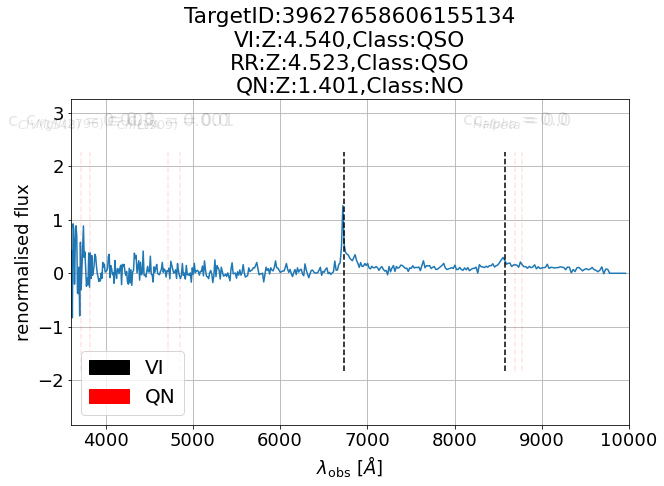

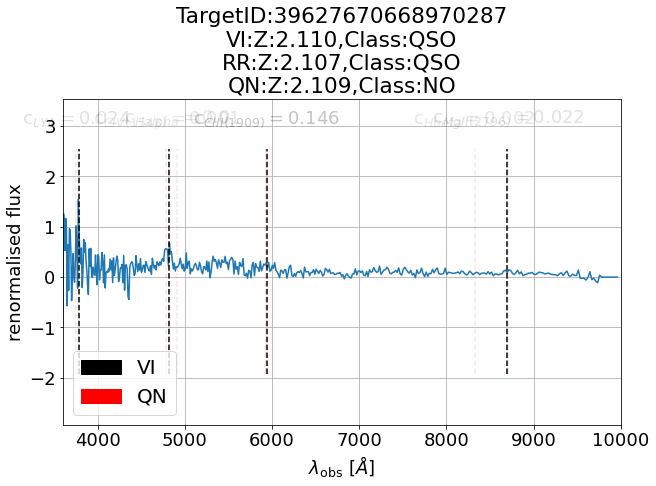

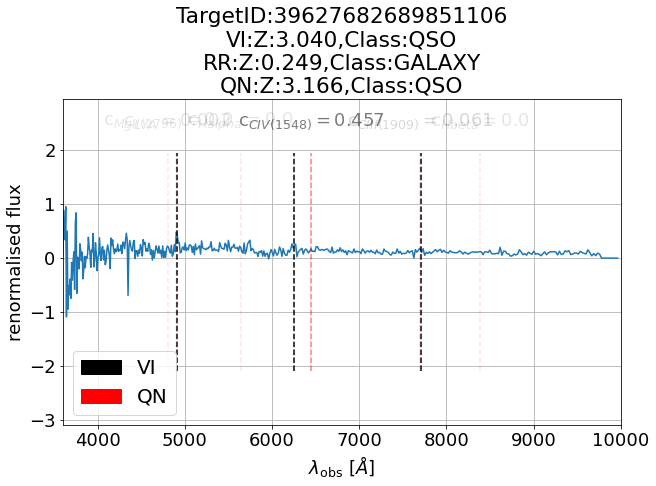

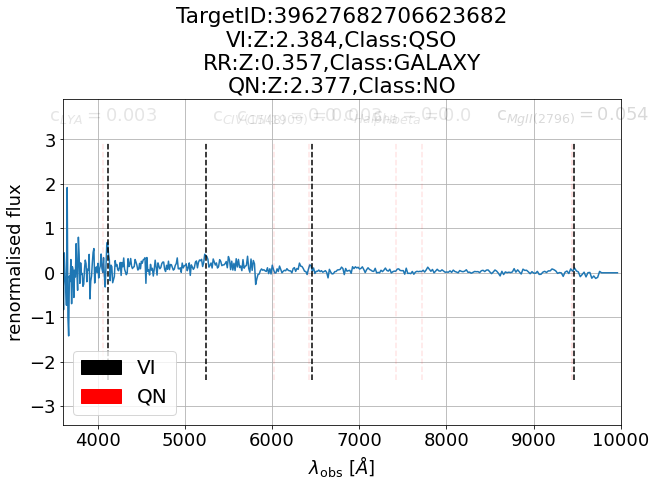

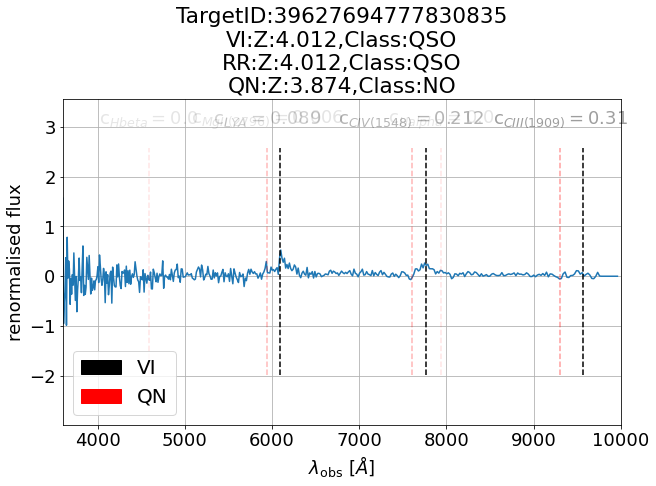

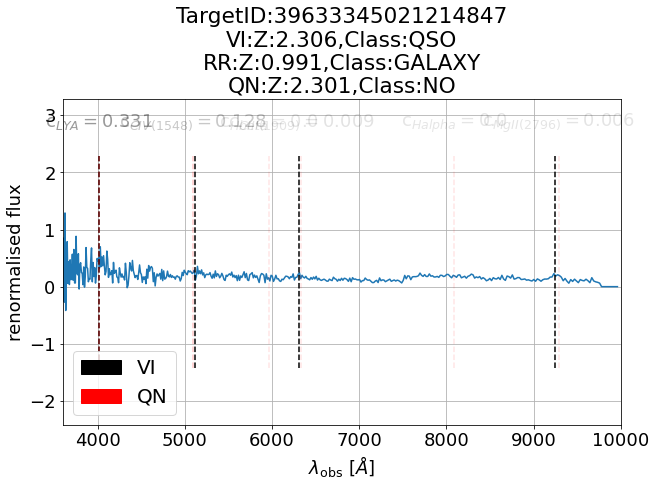

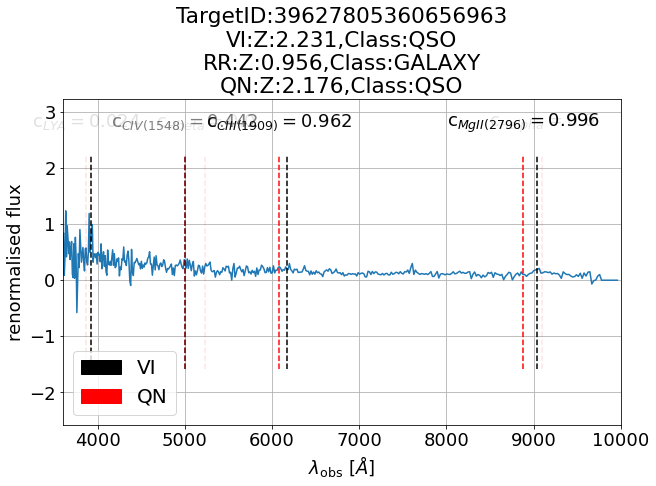

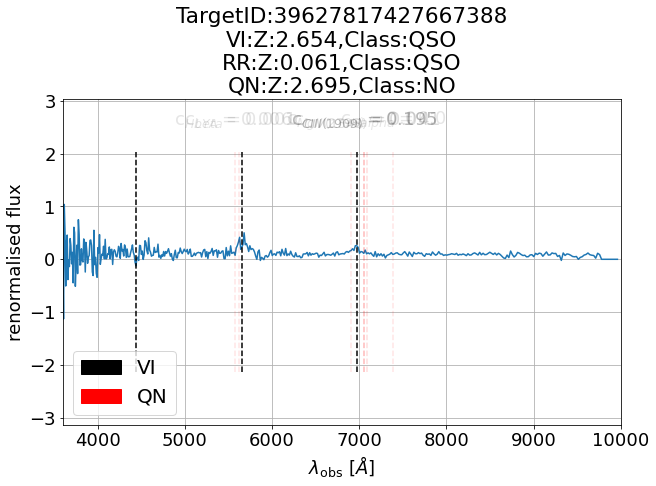

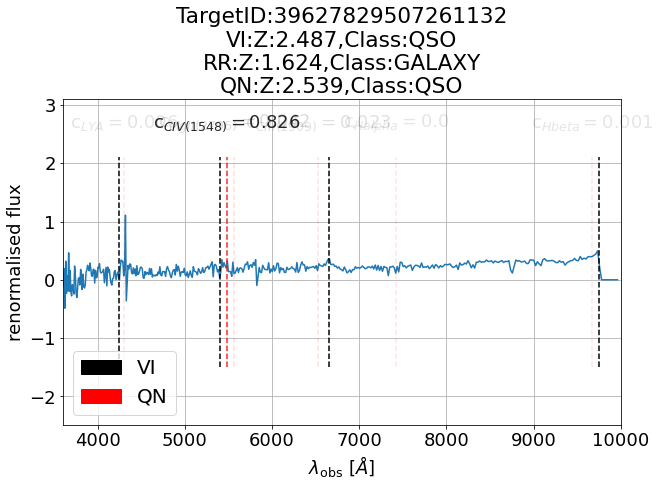

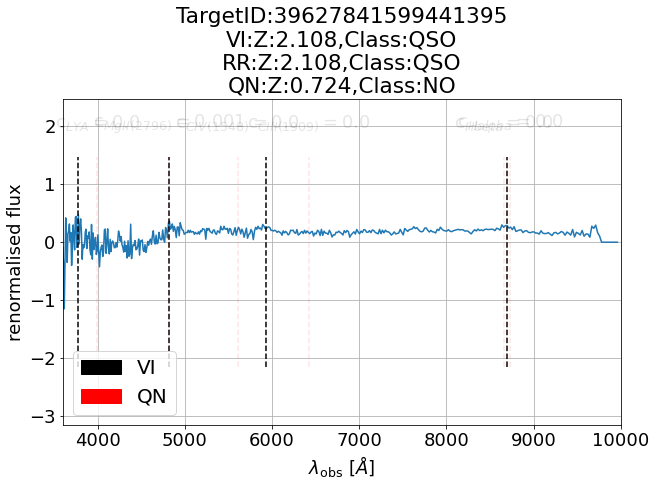

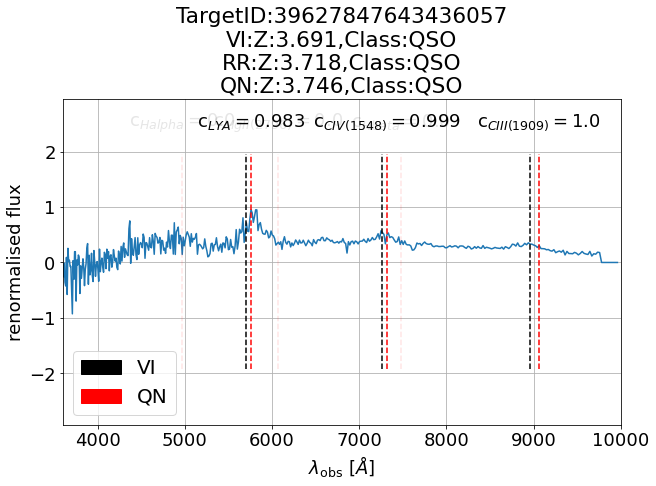

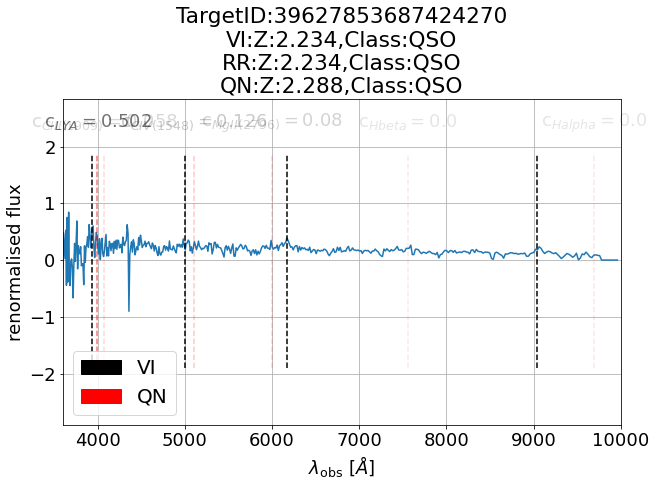

In [156]:
plot_spectrum(QN_false_z)